In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymrio
import scipy.io
from sklearn.linear_model import LinearRegression
from matplotlib import colors as mcolors
import math
#mcolors.to_rgba('darkblue')

In [307]:
XR = pd.read_excel('exchange rates.xlsx').loc[0]

In [308]:
Yhealth = pd.DataFrame()

for i in range(1995,2019,1):
    path = 'C:/Users/andrieba/Documents/3- Modélisation/1. Exiobase/Data/EXIO3/IOT_' + str(i) + '_pxp/Y.txt'
    Yhealth[i]=pd.read_csv(path,delimiter = "\t",header=[0,1],index_col=[0,1]).groupby(level='region',axis=1).sum().groupby(level='sector').sum().loc['Health and social work services (85)']
    
#on récupère PIB santé Exio euros pour comparer avec who dans l'optique d'utiliser le même taux qu'en 2000 pour 1995-2000

In [345]:
expendituresWHO = pd.read_excel('dépenses santé NHA 2018.xlsx',header=[0],index_col=[0]).groupby(level='region').sum()/1000
expendituresOECD_95_99 = pd.read_excel('dépenses santé OCDE.xlsx',header=[0],index_col=[0])
expendituresNHA = pd.concat([expendituresOECD_95_99,expendituresWHO],axis=1)
expendituresNHAeuros = expendituresNHA*XR
#from current US$ to current euros

In [347]:
shareTW = Yhealth.loc['TW']/(Yhealth.loc['CN']+Yhealth.loc['TW'])
#Taiwan is not in the GHED so we assume its share of China is that of Exiobase sector 'Health and social work services (85)'
expendituresNHAeuros49 = expendituresNHAeuros.T.drop(['CN'],axis=1)
expendituresNHAeuros49['CN'] = (1-shareTW).values*expendituresNHAeuros.T['CN']
expendituresNHAeuros49['TW'] = (shareTW).values*expendituresNHAeuros.T['CN']
expendituresNHAeuros49 = expendituresNHAeuros49.T

In [348]:
shareExioOverWho = (Yhealth/expendituresNHAeuros49).interpolate(method='linear').T.bfill().T
#We consider that for the period 1995-2000 the ratio of expenditures in the NHA format and of the exiobase sector (85) 
# stays constant for the countries not in the OECD database

expendituresNHAeuros49extrapolated = Yhealth/shareExioOverWho
# the total health expenditures in the NHA format extrapolated for years 1995-1999

In [349]:
health_shares_OECD = pd.read_excel('Health Shares OECD.xlsx',index_col=[0,1],header=[0,1])/100
health_shares_OECD = pd.DataFrame(health_shares_OECD.stack().T.interpolate(method='linear').bfill().stack(level=0).stack(level=0),columns=expendituresWHOeuros49.index)

For every retailer and every year we want to calculate a mean percentage for all the countries where data is available
We multiply the shares by the expenditures
In order to have NaN values in the expenditures vector we multiply and divide it by itself

In [350]:
shares_multiplied_by_expenditures = (health_shares_OECD.unstack(level=0)*expendituresWHOeuros49extrapolated.stack()).stack()
expenditures_with_appropriate_NaNValues = ((health_shares_OECD.unstack(level=0)*expendituresWHOeuros49extrapolated.stack())/health_shares_OECD.unstack(level=0)).stack()
mean_shares_OECD = (shares_multiplied_by_expenditures.sum(axis=1)/expenditures_with_appropriate_NaNValues.sum(axis=1)).reorder_levels([2,0,1])

In [351]:
for i in health_shares_OECD.index:
    for j in health_shares_OECD.columns:
        if math.isnan(health_shares_OECD.loc[i,j])==True:
            health_shares_OECD.loc[i,j] = mean_shares_OECD.loc[i]

health_shares_OECD['WM'] = mean_shares_OECD #only Israel with atypical "Retailers and other providers of medical goods"
health_shares_OECD = health_shares_OECD.unstack(level=0).groupby(level='sector').sum()
health_shares_OECD.loc['Health and social work services (85)'] = 1 - health_shares_OECD.sum()

In [358]:
i=2015
path = 'C:/Users/andrieba/Documents/3- Modélisation/1. Exiobase/Data/EXIO3/IOT_' + str(i) + '_pxp/Y.txt'
sectors = pd.read_csv(path,delimiter = "\t",header=[0,1],index_col=[0,1]).loc['FR'].index

In [359]:
Y_health_NHA = Y_health_shares.mul(expendituresWHOeuros49extrapolated.unstack(),axis=0)
Y_health_NHA = pd.DataFrame(Y_health_NHA,columns=sectors)

In [ ]:
#on veut avoir de quoi calculer rapidement des impacts en multipliant un LY par S
#l'enjeu est de créer les bons vecteurs Y, multiplier L, sommer selon axis=1
# partir de Y_health_sectors mais décomposer selon origine

In [388]:
LkY = pd.DataFrame()

for i in range(1995,2019,1):
    
    path = 'C:/Users/andrieba/Documents/3- Modélisation/1. Exiobase/Data/EXIO3/IOT_' + str(i) + '_pxp/Y.txt'
    Ycalc = pd.read_csv(path,delimiter = "\t",header=[0,1],index_col=[0,1]).swaplevel(axis=1).drop(['Gross fixed capital formation'],axis=1).groupby(level='region',axis=1).sum()
    
    path = 'C:/Users/andrieba/Documents/3- Modélisation/1. Exiobase/Data/EXIO3/IOT_' + str(i) + '_pxp/Z.txt'
    Z = pd.read_csv(path,delimiter='\t',header=[0,1],index_col=[0,1])
    
    if i in([2016,2017,2018]):
        path = 'C:/Users/andrieba/Documents/3- Modélisation/1. Exiobase/Data/Kbar/Kbar_' +str(i) + 'pxp.txt'
        Kbar = pd.read_csv(path,header=[0,1],index_col=[0,1])
    else:
        path = 'C:/Users/andrieba/Documents/3- Modélisation/1. Exiobase/Data/Kbar/Kbar_exio_v3_6_' +str(i) + 'pxp'
        mat = scipy.io.loadmat(path)
        Kbar = pd.DataFrame(mat['KbarCfc'].toarray(),index=Z.index,columns=Z.columns)
    
    Zcalc = Z + Kbar
    xcalc = pymrio.calc_x(Zcalc,Ycalc)
    Acalc = pymrio.calc_A(Zcalc,xcalc)
    Lk = pymrio.calc_L(Acalc)

    LkYhealth = pd.DataFrame()
    
    for j in Ycalc.columns: #regions
        
        Y_i_j_200_49 = (Ycalc[j].unstack().div(Ycalc[j].unstack().sum(),axis=1)*Y_health_NHA.loc[i].loc[j]).stack()
        
        LkYhealth[j] = Lk.mul(Y_i_j_200_49,axis=1).groupby(level='sector',axis=1).sum()[health_shares_OECD.index].stack()
        
    LkYhealth.to_csv('LkYhealth/LkYhealth'+str(i)+'.txt')
        
#environ 1h de compilation

In [391]:
LkY=pd.DataFrame()
for i in range(1995,2019,1):
    LkY[i] = pd.read_csv('LkYhealth/LkYhealth'+str(i)+'.txt',header=[0],index_col=[0,1,2]).stack()
LkY = LkY.unstack(level=2).unstack(level=2)

In [400]:
SLkY = pd.DataFrame()
for i in range(1995,2019,1):
    path = 'C:/Users/andrieba/Documents/3- Modélisation/1. Exiobase/Data/EXIO3/IOT_' + str(i) + '_pxp/impacts/S.txt'
    S = pd.read_csv(path,delimiter = "\t",header=[0,1],index_col=[0])
    SLkYi = pd.DataFrame()
    for j in S.index:
        SLkYi[j] = LkY[i].mul(S.loc[j],axis=0).sum()
    SLkY[i] = SLkYi.stack()
SLkY_impacts = SLkY.unstack(level=1).unstack(level=0)
SLkY_impacts.to_csv('SLKY_impacts.txt')

SLkY = pd.DataFrame()
for i in range(1995,2019,1):
    path = 'C:/Users/andrieba/Documents/3- Modélisation/1. Exiobase/Data/EXIO3/IOT_' + str(i) + '_pxp/satellite/S.txt'
    S = pd.read_csv(path,delimiter = "\t",header=[0,1],index_col=[0])
    SLkYi = pd.DataFrame()
    for j in S.index:
        SLkYi[j] = LkY[i].mul(S.loc[j],axis=0).sum()
    SLkY[i] = SLkYi.stack()
SLkY_satellite = SLkY.unstack(level=1).unstack(level=0)
SLkY_satellite.to_csv('SLKY_satellite.txt')

In [449]:
impacts = SLkY_impacts.stack().unstack(level=0).sum().unstack()
impacts_world = impacts.unstack(level=0).sum().unstack(level=0)

satellite = SLkY_satellite.stack().unstack(level=0).sum().unstack()
satellite_world = satellite.unstack(level=0).sum().unstack(level=0)

In [467]:
QualityIndex = pd.read_excel('Health Access and Quality Index.xlsx',header=0,index_col=0)
QualityIndex = pd.DataFrame(QualityIndex,columns=Y_health_NHA.unstack().index).T.interpolate(method='linear').bfill().T.drop([2017,2018],axis=1)

In [468]:
QualityIndex

,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
AT,84.4,85.00,85.60,86.20,86.80,87.4,87.90,88.40,88.90,89.40,...,90.58,90.92,91.26,91.6,91.983333,92.366667,92.75,93.133333,93.516667,93.9
AU,87.2,87.84,88.48,89.12,89.76,90.4,90.86,91.32,91.78,92.24,...,93.34,93.66,93.98,94.3,94.566667,94.833333,95.10,95.366667,95.633333,95.9
BE,83.9,84.34,84.78,85.22,85.66,86.1,86.62,87.14,87.66,88.18,...,89.30,89.60,89.90,90.2,90.650000,91.100000,91.55,92.000000,92.450000,92.9
BG,66.0,66.40,66.80,67.20,67.60,68.0,68.52,69.04,69.56,70.08,...,71.76,72.34,72.92,73.5,74.116667,74.733333,75.35,75.966667,76.583333,77.2
BR,51.4,52.18,52.96,53.74,54.52,55.3,55.90,56.50,57.10,57.70,...,59.26,59.74,60.22,60.7,61.216667,61.733333,62.25,62.766667,63.283333,63.8
CA,85.7,86.42,87.14,87.86,88.58,89.3,89.68,90.06,90.44,90.82,...,91.84,92.16,92.48,92.8,92.966667,93.133333,93.30,93.466667,93.633333,93.8
CH,89.6,90.00,90.40,90.80,91.20,91.6,91.96,92.32,92.68,93.04,...,93.80,94.00,94.20,94.4,94.600000,94.800000,95.00,95.200000,95.400000,95.6
CN,47.6,48.74,49.88,51.02,52.16,53.3,55.04,56.78,58.52,60.26,...,65.72,67.58,69.44,71.3,72.400000,73.500000,74.60,75.700000,76.800000,77.9
CY,73.0,74.00,75.00,76.00,77.00,78.0,79.02,80.04,81.06,82.08,...,85.22,86.28,87.34,88.4,88.716667,89.033333,89.35,89.666667,89.983333,90.3
CZ,77.5,78.28,79.06,79.84,80.62,81.4,81.90,82.40,82.90,83.40,...,84.90,85.40,85.90,86.4,86.833333,87.266667,87.70,88.133333,88.566667,89.0


In [429]:
impacts_world[['Water Consumption Blue - Total','Water Withdrawal Blue - Total','SOx','NOx','Nitrogen','GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)']]

,Water Consumption Blue - Total,Water Withdrawal Blue - Total,SOx,NOx,Nitrogen,"GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)"
1995,18250.024392,40655.976443,5.163920e+09,3.320491e+09,1.130641e+09,1.241880e+12
1996,17718.953069,41457.698567,4.983789e+09,3.276003e+09,1.110518e+09,1.244175e+12
1997,25782.992493,48510.817432,6.073818e+09,3.872152e+09,1.481391e+09,1.493964e+12
1998,21060.202007,41410.355428,5.326564e+09,3.339520e+09,1.214142e+09,1.295465e+12
1999,25448.568964,43858.059725,5.483693e+09,3.474282e+09,1.336416e+09,1.334317e+12
2000,26056.952610,53680.606960,6.083709e+09,4.046099e+09,1.326629e+09,1.586940e+12
2001,23691.516288,44674.802690,5.242193e+09,3.431933e+09,1.224055e+09,1.378679e+12
2002,25108.959561,42785.932874,5.338398e+09,3.475985e+09,1.286240e+09,1.406660e+12
2003,29895.408376,53681.399790,6.601320e+09,4.295177e+09,1.615173e+09,1.761718e+12
2004,29915.625785,42918.585172,5.742363e+09,3.785423e+09,1.506727e+09,1.566305e+12


In [422]:
impacts['GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)'].unstack().loc[2015]

AT    6.110167e+09
AU    3.650081e+10
BE    1.299529e+10
BG    2.487414e+09
BR    3.218104e+10
CA    3.356730e+10
CH    1.614056e+10
CN    6.969672e+11
CY    5.309677e+08
CZ    6.474887e+09
DE    6.349543e+10
DK    6.003163e+09
EE    6.547563e+08
ES    1.805795e+10
FI    3.975611e+09
FR    3.168546e+10
GB    4.267992e+10
GR    4.397361e+09
HR    8.513356e+08
HU    3.207710e+09
ID    2.509628e+10
IE    3.443141e+09
IN    4.588175e+10
IT    2.982509e+10
JP    1.163606e+11
KR    5.122525e+10
LT    5.170320e+08
LU    1.917009e+09
LV    5.203344e+08
MT    9.434477e+08
MX    1.803846e+10
NL    1.377356e+10
NO    3.605877e+09
PL    1.055266e+10
PT    2.903906e+09
RO    2.278075e+09
RU    2.562002e+10
SE    4.532141e+09
SI    1.931526e+09
SK    2.925323e+09
TR    1.642372e+10
TW    5.653317e+09
US    4.991695e+11
WA    4.944944e+10
WE    1.021772e+10
WF    4.815618e+10
WL    5.314246e+10
WM    8.069297e+10
ZA    1.629579e+10
Name: 2015, dtype: float64

In [416]:
impacts['GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)'].unstack()['FR']/1000000000

1995    64.881102
1996    45.375031
1997    28.914893
1998    46.165204
1999    31.245219
2000    27.402948
2001    29.061306
2002    32.884565
2003    35.851576
2004    33.441964
2005    34.133899
2006    33.927038
2007    32.969611
2008    35.514541
2009    27.106095
2010    30.816924
2011    31.312912
2012    34.542660
2013    32.945387
2014    32.475945
2015    31.685458
2016     0.000000
2017     0.000000
2018     0.000000
Name: FR, dtype: float64

In [447]:
pd.DataFrame(SLkY_satellite.index).head(130)

,0
0,Taxes less subsidies on products purchased: Total
1,Other net taxes on production
2,"Compensation of employees; wages, salaries, & ..."
3,"Compensation of employees; wages, salaries, & ..."
4,"Compensation of employees; wages, salaries, & ..."
...,...
125,Hg - non combustion - Glass production - air
126,"Hg - non combustion - Nickel, unwrought - air"
127,"Hg - non combustion - Pig iron production, bla..."
128,Hg - non combustion - Production of coke oven ...


In [441]:
pd.DataFrame(impacts_world[['Domestic Extraction Used - Crop and Crop Residue',
'Domestic Extraction Used - Grazing and Fodder',
'Domestic Extraction Used - Forestry and Timber',
'Domestic Extraction Used â Fisheries',
'Domestic Extraction Used - Non-metalic Minerals',
'Domestic Extraction Used - Iron Ore',
'Domestic Extraction Used - Non-ferous metal ores',
'Unused Domestic Extraction - Crop and Crop Residue',
'Unused Domestic Extraction - Grazing and Fodder',
'Unused Domestic Extraction - Forestry and Timber',
'Unused Domestic Extraction â Fisheries',
'Unused Domestic Extraction - Coal and Peat',
'Unused Domestic Extraction - Oil and Gas',
'Unused Domestic Extraction - Non-metalic Minerals',
'Unused Domestic Extraction - Iron Ore',
'Unused Domestic Extraction - Non-ferous metal ores'
]].loc[2015]/7000000000*1000000).round()

,2015
Domestic Extraction Used - Crop and Crop Residue,43.0
Domestic Extraction Used - Grazing and Fodder,66.0
Domestic Extraction Used - Forestry and Timber,19.0
Domestic Extraction Used â Fisheries,0.0
Domestic Extraction Used - Non-metalic Minerals,304.0
Domestic Extraction Used - Iron Ore,17.0
Domestic Extraction Used - Non-ferous metal ores,42.0
Unused Domestic Extraction - Crop and Crop Residue,22.0
Unused Domestic Extraction - Grazing and Fodder,4.0
Unused Domestic Extraction - Forestry and Timber,3.0


In [435]:
pd.DataFrame(impacts_world.columns).head(40)

,0
0,Acidification endpoint | ILCD recommended CF |...
1,Acidification midpoint | ILCD recommended CF |...
2,Carbon dioxide (CO2) CO2EQ IPCC categories 1 t...
3,Carbon dioxide (CO2) Fuel combustion
4,Carbon dioxide (CO2) Fuel combustion and cement
5,Carbon dioxide (CO2) IPCC categories 1 to 4 an...
6,Carcinogenic effects on humans (E.E) | ECOINDI...
7,Carcinogenic effects on humans (H.A) | ECOINDI...
8,Carcinogenic effects on humans (I.I) | ECOINDI...
9,"Climate change endpoint, ecosystems | ILCD rec..."


In [18]:
Sghg = pd.DataFrame()
for i in range(1995,2016,1):
    path = 'Exiobase ppp/Exiobase Shift/EXIO3/IOT_' + str(i) + '_pxp/impacts/S.txt'
    S = pd.read_csv(path,delimiter = "\t",header=[0,1],index_col=[0])
    Sghg[i] = S.loc['GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)']

In [52]:
Sco2 = pd.DataFrame()
for i in range(1995,2016,1):
    path = 'Exiobase ppp/Exiobase Shift/EXIO3/IOT_' + str(i) + '_pxp/impacts/S.txt'
    S = pd.read_csv(path,delimiter = "\t",header=[0,1],index_col=[0])
    Sco2[i] = S.loc['Carbon dioxide (CO2) IPCC categories 1 to 4 and 6 to 7 (excl land use, land use change and forestry)']

In [240]:
Sfinal = pd.DataFrame()
for i in range(1995,2016,1):
    path = 'Exiobase ppp/Exiobase Shift/EXIO3/IOT_' + str(i) + '_pxp/satellite/S.txt'
    S = pd.read_csv(path,delimiter = "\t",header=[0,1],index_col=[0])
    Sfinal[i] = S.loc['Energy Carrier Net Total']-S.loc['Energy Carrier Net LOSS']

In [48]:
LYagg = LY.stack().unstack(level=2).sum(axis=1)

In [49]:
result = LYagg.unstack(level=2).mul(Sghg.stack(),axis=0).unstack().sum()

In [53]:
resultco2 = LYagg.unstack(level=2).mul(Sco2.stack(),axis=0).unstack().sum()

In [241]:
resultfinal = LYagg.unstack(level=2).mul(Sfinal.stack(),axis=0).unstack().sum()

In [ ]:
pop=pd.read_excel('pop.xlsx',index_col=[0])

pichler = pd.read_excel('pichler.xlsx',index_col=0)
arup = pd.read_excel('arup.xlsx',index_col=0)
lenzen = pd.read_excel('lenzen.xlsx',index_col=0)

df_lenzen=pd.concat([(result.unstack()[2015]/1000).loc[lenzen.index]/pop[2015].loc[lenzen.index]/1000,lenzen['ges 2015']/pop[2015].loc[lenzen.index]*1000,],keys=['calc ges','lenzen'],axis=1)
df_arup=pd.concat([(result.unstack()[2014]/1000).loc[arup.index]/pop[2014].loc[arup.index]/1000,arup['ges 2014']/pop[2014].loc[arup.index]*1000,],keys=['calc ges','arup'],axis=1)


In [137]:
df=pd.concat([(resultco2.unstack()[2014]/1000).loc[pichler.index]/pop[2014].loc[pichler.index]*1000,pichler['CO2 2014']/pop[2014].loc[pichler.index]*1000,(result.unstack()[2014]/1000).loc[pichler.index]/pop[2014].loc[pichler.index]/1000],keys=['calc co2','pichler','calc ges'],axis=1)

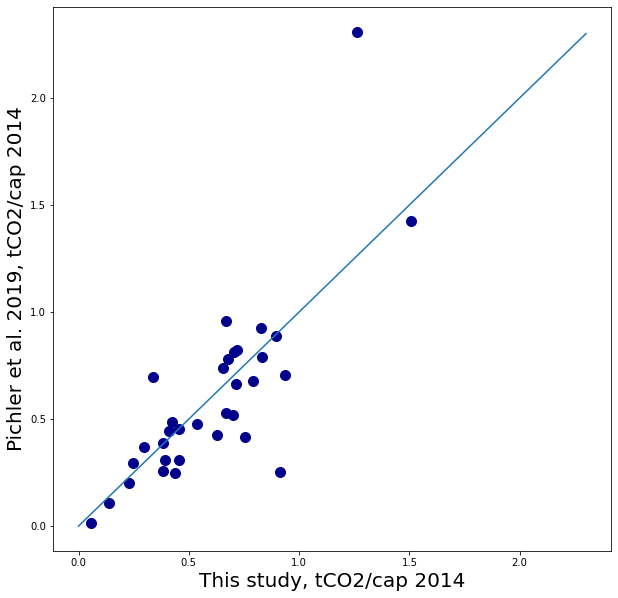

In [301]:
fig, axes = plt.subplots(1, figsize=(10, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

axes.scatter(x=df['pichler'],y=df['calc co2'],s=100,color='darkblue')
axes.set_xlabel('This study, tCO2/cap 2014',fontsize=20)
axes.set_ylabel('Pichler et al. 2019, tCO2/cap 2014',fontsize=20)
#axes.legend()
axes.plot([0,2.3],[0,2.3])

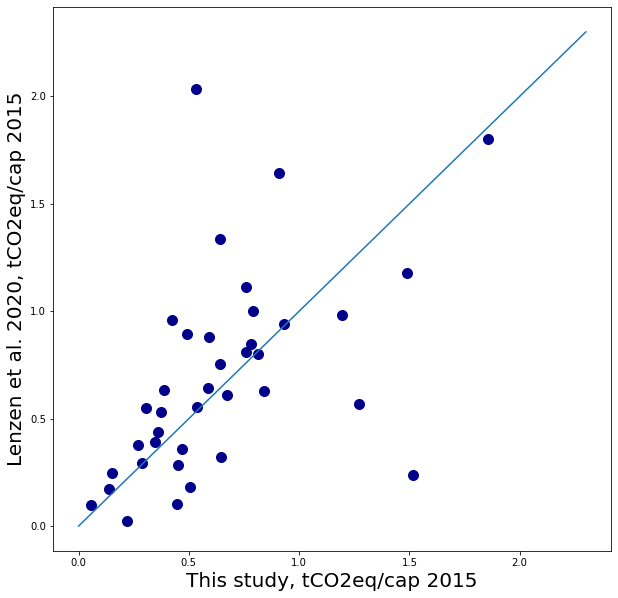

In [305]:
fig, axes = plt.subplots(1, figsize=(10, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

axes.scatter(x=df_lenzen['lenzen'],y=df_lenzen['calc ges'],s=100,color='darkblue')
axes.set_xlabel('This study, tCO2eq/cap 2015',fontsize=20)
axes.set_ylabel('Lenzen et al. 2020, tCO2eq/cap 2015',fontsize=20)
#axes.legend()
axes.plot([0,2.3],[0,2.3])

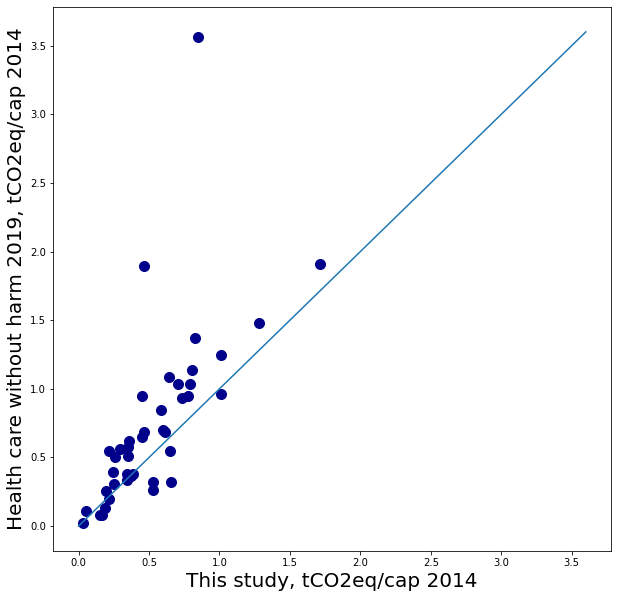

In [310]:
fig, axes = plt.subplots(1, figsize=(10, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

axes.scatter(x=df_arup['arup'],y=df_arup['calc ges'],s=100,color='darkblue')
axes.set_xlabel('This study, tCO2eq/cap 2014',fontsize=20)
axes.set_ylabel('Health care without harm 2019, tCO2eq/cap 2014',fontsize=20)
#axes.legend()
axes.plot([0,3.6],[0,3.6])

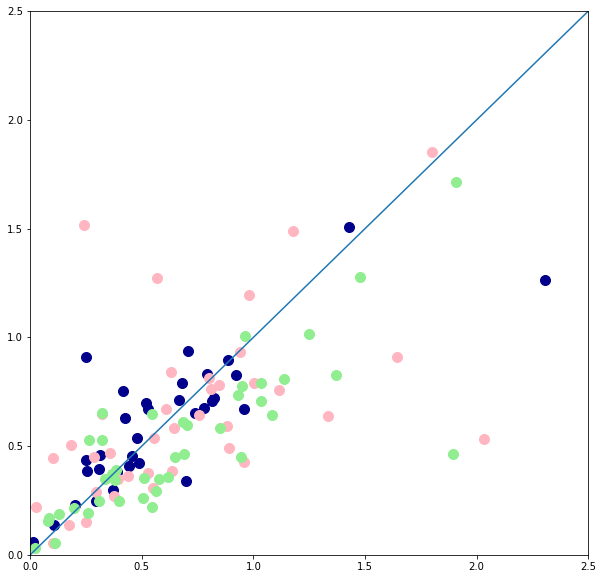

In [167]:
fig, axes = plt.subplots(1, figsize=(10, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

axes.scatter(y=df['pichler'],x=df['calc co2'],s=100,color='darkblue')
#axes.scatter(y=df['calc ges'],x=df['calc co2'],s=100,color='lightpink')
axes.scatter(y=df_lenzen['lenzen'],x=df_lenzen['calc ges'],s=100,color='lightpink')
axes.scatter(y=df_arup['arup'],x=df_arup['calc ges'],s=100,color='lightgreen')
axes.set_ylim([0,2.5])
axes.set_xlim([0,2.5])
axes.plot([0,3.7],[0,3.7])

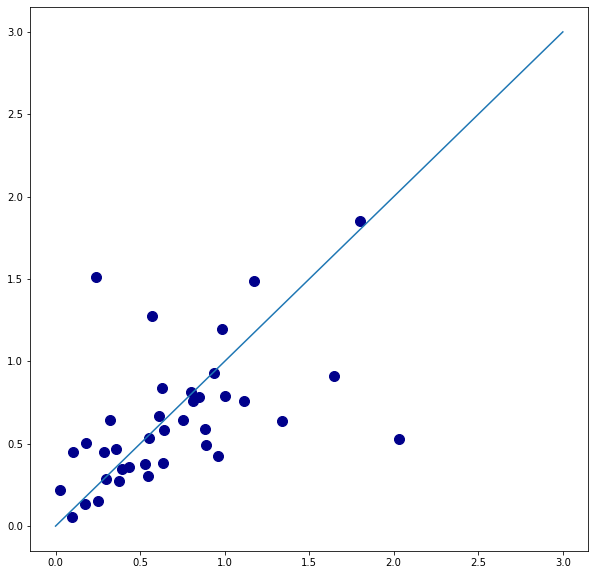

In [334]:
fig, axes = plt.subplots(1, figsize=(10, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

axes.scatter(y=df_lenzen['lenzen'],x=df_lenzen['calc ges'],s=100,color='darkblue')
#axes.scatter(y=df['calc ges'],x=df['calc co2'],s=100,color='lightpink')
#axes.set_ylim([0,2.5])
#axes.set_xlim([0,2.5])
axes.plot([0,3],[0,3])

In [169]:
pichler.index

Index(['AU', 'AT', 'BE', 'CA', 'CH', 'CN', 'CZ', 'DE', 'DK', 'ES', 'EE', 'FI',
       'FR', 'GB', 'GR', 'HU', 'IN', 'IE', 'IT', 'JP', 'KR', 'LU', 'LV', 'MX',
       'NL', 'NO', 'PL', 'PT', 'SK', 'SI', 'SE', 'TR', 'US'],
      dtype='object', name='region')

In [ ]:
fig, axes = plt.subplots(1, figsize=(10, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

axes.scatter(y=df['calc co2'],x=df['pichler'],s=100,color='darkblue')
axes.scatter(y=df['calc ges'],x=df['pichler'],s=100,color='lightpink')
#axes.set_ylim([0,2.5])
#axes.set_xlim([0,2.5])
axes.plot([0,3],[0,3])

In [ ]:
fig, axes = plt.subplots(1, figsize=(25, 25))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

xlab = ['CPI: 01 - Food [..]','CPI: 02 - Alcohool [..]','CPI: 03 - Clothing [..]','CPI: 04 - Housing [..]','CPI: 05 - Furnishings [..]','CPI: 06 - Health', 'CPI: 07 - Transport', 'CPI: 08 - Communication','CPI: 09 - Recreation [..]', 'CPI: 10 - Education','CPI: 11 - Restaurants [..]','CPI: 12 - Miscellaneous [..]','TOTAL']

df = table1['Current € gap']
df2 = table1['Constant € gap']

k=1

axes2 = axes.twinx()

for i in df.columns:
    
    l=0
    axes.axvline(x=k-0.5, ymin=0, ymax=1, color='gray')
    for j in df.index:
        l+=1
axes.scatter(y=df[i].loc[j],x=k-0.25,s=50+40*l,color='lightpink')
axes.scatter(y=df2[i].loc[j],x=k+0.25,s=50+40*l,color='powderblue')

In [180]:
indexUSinf15unstacked = pd.read_excel('indexUSinf15.xlsx',index_col=[0,1,2])[0].unstack()['CPI: 06 - Health']

In [220]:
Y_health_sectors_index_inf = Y_health_sectors.stack(level=0).sum(axis=1).unstack().drop([1995])/indexUSinf15unstacked.unstack()

In [269]:
aFPges_2015_euros = result.unstack().drop([1995],axis=1).T/Y_health_sectors_index_inf/1000000

In [270]:
aFPges_current_euros = result.unstack().drop([1995],axis=1).T/Y_health_sectors.stack(level=0).sum(axis=1).unstack().drop([1995])/1000000

In [251]:
aFPindexinf = resultfinal.unstack().drop([1995],axis=1).T/Y_health_sectors_index_inf

In [252]:
aFP = resultfinal.unstack().drop([1995],axis=1).T/Y_health_sectors.stack(level=0).sum(axis=1).unstack().drop([1995])

In [275]:
aFPges_2015_euros.index

Int64Index([1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
            2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015],
           dtype='int64')

<AxesSubplot:>

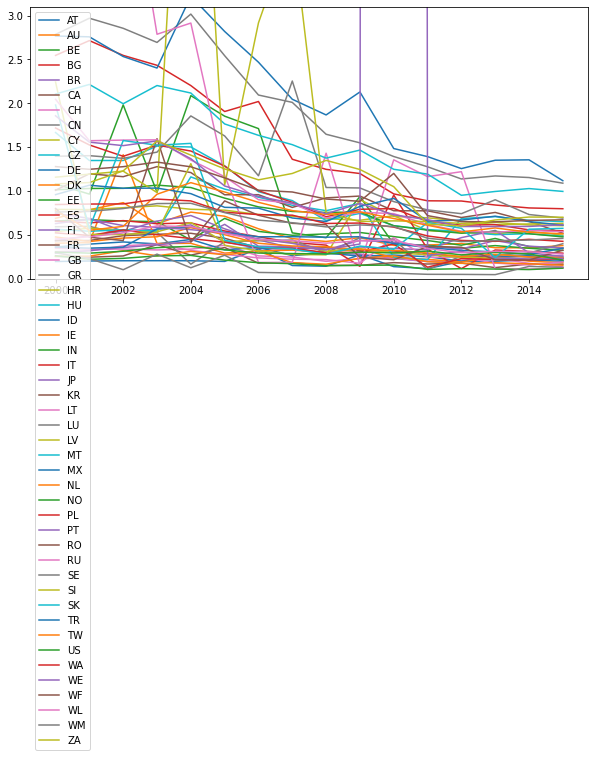

In [280]:
aFPges_current_euros.drop([1996,1997,1998,1999]).plot(ylim=[0,3.1])

<AxesSubplot:>

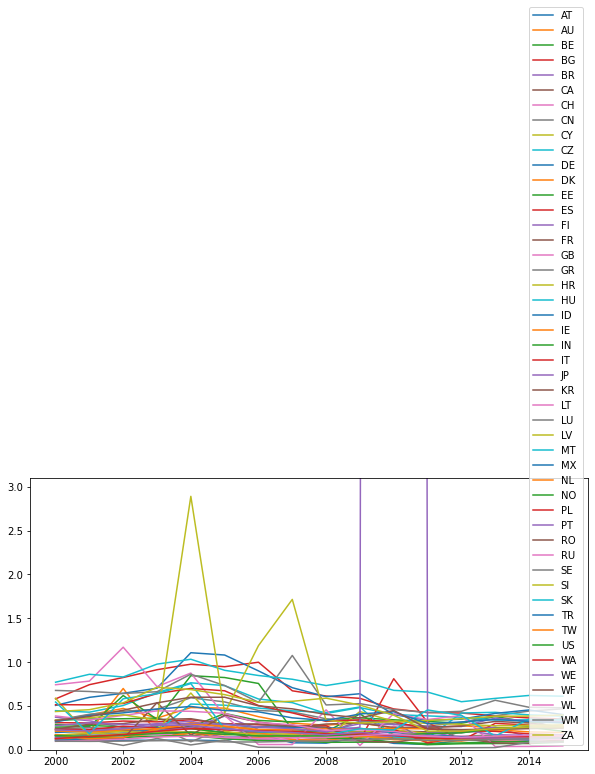

In [282]:
aFPges_2015_euros.drop([1996,1997,1998,1999]).plot(ylim=[0,3.1])

<AxesSubplot:>

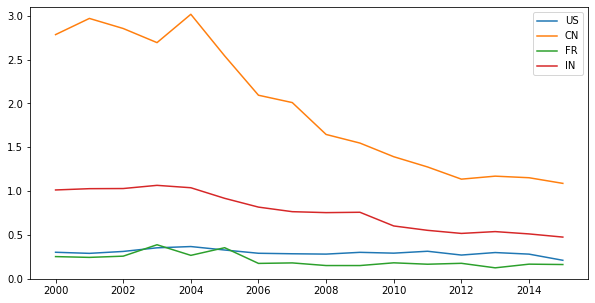

In [278]:
aFPges_current_euros[['US','CN','FR','IN']].drop([1996,1997,1998,1999]).plot(ylim=[0,3.1])

<AxesSubplot:>

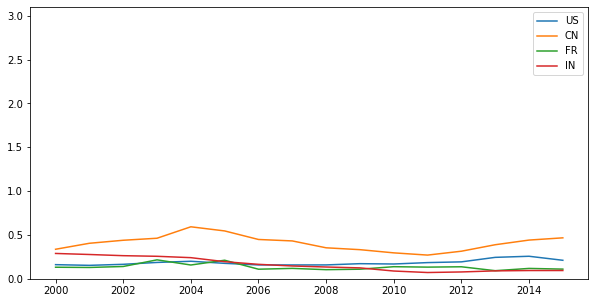

In [279]:
aFPges_2015_euros[['US','CN','FR','IN']].drop([1996,1997,1998,1999]).plot(ylim=[0,3.1])

<AxesSubplot:>

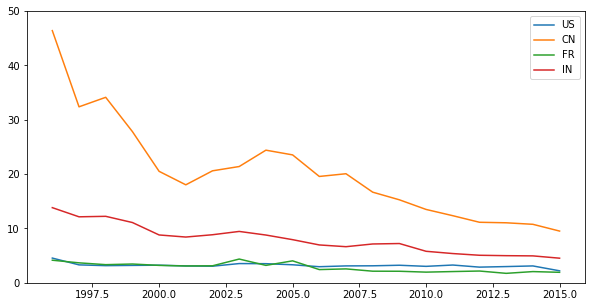

In [256]:
aFP[['US','CN','FR','IN']].plot(ylim=(0,50))

<AxesSubplot:>

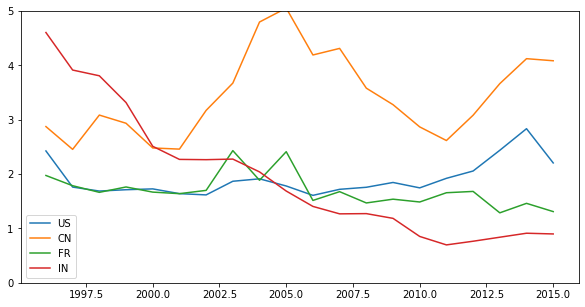

In [260]:
aFPindexinf[['US','CN','FR','IN']].plot(ylim=(0,5))

<AxesSubplot:>

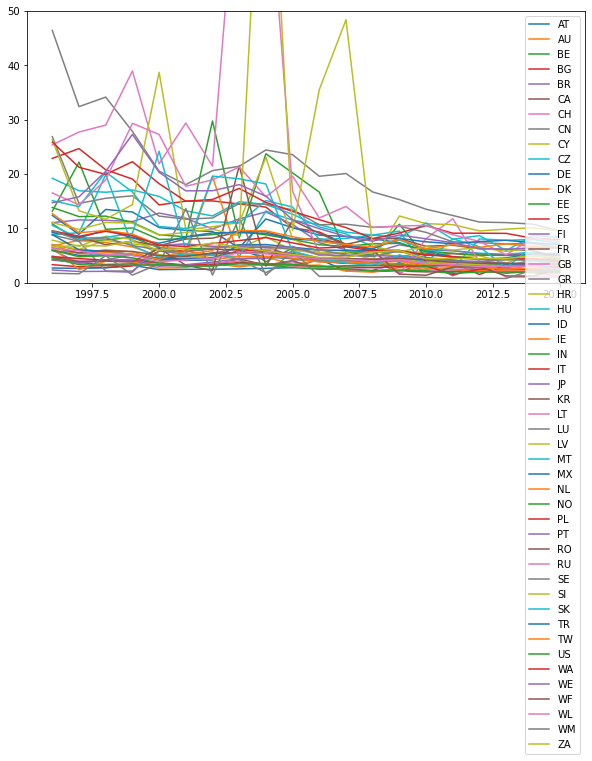

In [258]:
aFP.plot(ylim=(0,50))

<AxesSubplot:>

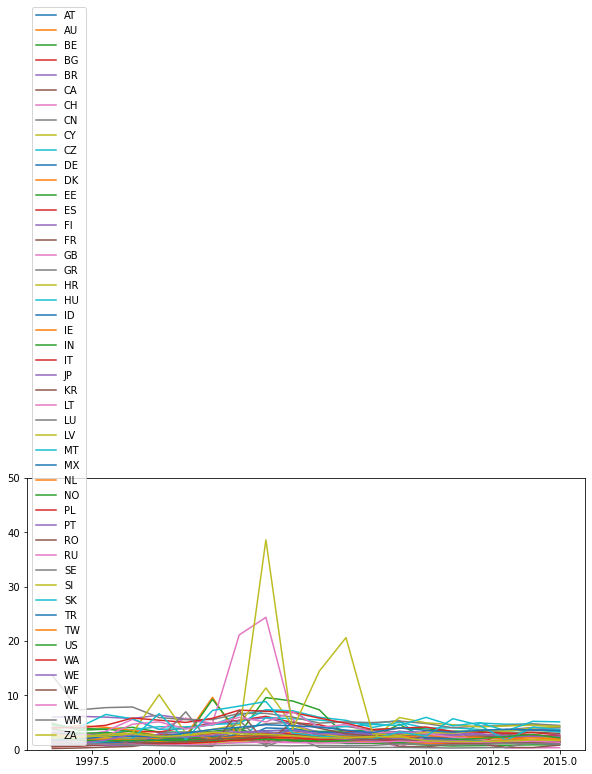

In [259]:
aFPindexinf.plot(ylim=(0,50))